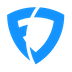

# <u>Predicting Field Goal Probability</u>

Keith Goldner (keith.goldner@fanduel.com) • Juliette Gorson (juliette.gorson@fanduel.com) • Matt Hammond (matt.hammond@fanduel.com)

Welcome to our code for our workshop at the 2022 MIT Sloan Sports Analytics Conference:<br /> 
<b>How to Win at Sports Betting: Building Models & Pricing Odds with Data Science</b>

In discussing the process of creating a model - one of the steps we walked through was <b>data cleaning</b>. We mentioned some examples, but emphasized that this is the longest part of the model building process; data errors can be tough. We're going to walkthrough our coding process at a high level with you now, but we have provided our data and our code for you to take a look at in more detail. <i>Know that we left some data uncleaned</i>. When you have the opportunity to walk through our example on your own, try to find what we missed!

<i>Optional:</i> At the end of the code, we spelled out the error and how it can affect the model building process. Try re-cleaning the data on your own - does it change our model results?

Now, onto the code.

First, we import all of the necessary packages and settings that we will need.

In [1]:
import pandas as pd
import numpy as np
import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
import statsmodels.api as sm

from xgboost import XGBClassifier
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("font", size=14)

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

Next, we will read in our data and inspect it, checking the number of columns/rows and what those columns are.

In [2]:
df = pd.read_csv('historical_field_goal_data.csv',header=0)
print(f'Rows : {df.shape[0]}')
print(f'Columns : {df.shape[1]}')
pprint.pprint(df.dtypes)

Rows : 9286
Columns : 36
season                   int64
week                     int64
away                    object
home                    object
stadium                 object
temperature            float64
humidity               float64
wind_speed             float64
wind_direction          object
condition               object
surface                 object
ou                     float64
home_spread            float64
away_score               int64
home_score               int64
off                     object
def                     object
quarter                  int64
minutes                  int64
seconds                  int64
offense_score            int64
defense_score            int64
timeouts_offense         int64
timeouts_defense         int64
down                     int64
yards_to_go              int64
yards_from_own_goal      int64
points                   int64
penalty                  int64
fumble                   int64
block                    int64
play_id       

<b>Distance</b> came in as an integer so we're going to convert it to a float for modeling purposes.

In [3]:
df['distance'] = df['distance'].astype(float)

We want to identify all of the possible conditions and venues that might bias our data or effect the field goal probability. In particular, we're looking for stadiums <b>at altitude</b> (<b>Mile High</b> and <b>Azteca</b>), <b>domed or stadiums with roofs</b>, and <b>types of precipitation</b>.

In [4]:
#get unique stadiums
print(df.stadium.unique())

['MetLife Stadium' 'Soldier Field' 'Cleveland Browns Stadium'
 'Arrowhead Stadium' 'Ford Field' 'Mercedes-Benz Superdome'
 'Reliant Stadium' 'LP Field' 'Mall of America Field at HHH Metrodome'
 'Raymond James Stadium' 'University of Phoenix Stadium' 'Lambeau Field'
 'Sports Authority Field at Mile High' 'M&T Bank Stadium'
 'O.co Coliseum Oakland' 'Paul Brown Stadium' 'Ralph Wilson Stadium'
 'Lucas Oil Stadium' 'Lincoln Financial Field' 'EverBank Field'
 'Bank of America Stadium' 'Gillette Stadium' 'Edward Jones Dome'
 'CenturyLink Field' 'Qualcomm Stadium' 'Sun Life Stadium' 'Heinz Field'
 'Candlestick Park' 'Georgia Dome' 'Cowboys Stadium' 'FedEx Field'
 'Wembley Stadium' 'Rogers Centre' 'FirstEnergy Stadium' 'AT&T Stadium'
 'NRG Stadium' 'TCF Bank Stadium' "Levi's Stadium"
 'Los Angeles Memorial Coliseum' 'U.S. Bank Stadium' 'Twickenham'
 'New Era Field' 'Nissan Stadium' 'StubHub Center'
 'Oakland-Alameda County Coliseum' 'Mercedes-Benz Stadium'
 'Hard Rock Stadium' 'Twickenham Stadi

In [5]:
#get unique conditions
print(df.condition.unique())

['Fair' 'Partly Cloudy' 'Sunny' 'Dome' 'Closed Roof' 'Cloudy' 'Clear'
 'Mostly Sunny' 'Rain' 'Mostly Cloudy' nan 'Partly Sunny' 'Chance Rain'
 'Light Rain' 'Snow' 'Windy' 'Hazy' 'Thunderstorms' 'Light Snow'
 'Flurries' 'Covered Roof' 'Light Showers' 'Overcast' 'Showers' 'Cold'
 'Raining' 'Cloiudy' 'Foggy']


Now that we have our condition lists, let's create some binary indicators with which we can filter and model.

In [6]:
#identify stadiums at altitude
altitude_stadiums_list = ['Empower Field at Mile High', 'Estadio Azteca', 'Azteca Stadium', 'Sports Authority Field at Mile High', 'Broncos Stadium at Mile High']
df['at_altitude'] = df['stadium'].isin(altitude_stadiums_list).astype(int)

#identify closed roof/dome stadiums
closed_roof_condition_list = ['Closed Roof', 'Covered Roof', 'Dome']
df['is_closed_roof'] = df['condition'].isin(closed_roof_condition_list).astype(int)

#identify precipitation
precipitating_condition_list = ['Flurries', 'Light Rain', 'Light Showers', 'Light Snow', 'Rain', 'Raining', 'Showers', 'Snow', 'Thunderstorms']
df['is_precipitating'] = df['condition'].isin(precipitating_condition_list).astype(int)

#identify end of half or end of game field goals
df['is_end_of_half_or_game'] = (((df['quarter'] == 2) | (df['quarter'] >= 4)) & (df['minutes'] == 0) & (df['seconds'] <= 30)).astype(int)                                                                                            


## Feature Engineering

Next, we're going to do some <b>feature engineering</b>. We want metrics to describe <b>kicker accuracy</b> and <b>kicker leg strength</b>. 

For kicker accuracy, we're going to create our own metric <b><i>field goals over expectation</i></b>. Here, we will take our simple, league-average logistic model that is based solely on distance and give kickers credit for making field goals, while knocking them for missing. So, if a league-average kicker has a 61% chance to make a field goal and our kicker makes it, they would get (1 - 0.61) or <b>+0.39</b> field goals over expectation. If they were to miss it they would get (0 - 0.61) or <b>-0.61</b> field goals over expectation. We will take their average field goals over expectation to not bias kickers based on the number of attempts. 

Similarly, for leg strength, we will take the average of the 5 longest kicks attempted that were not done at altitude or in the final 30 seconds of the 1st half. 

In [7]:
#let's generate kicker analytics

#drop those at altitude
field_goals_for_kicker_analysis = df[(df['at_altitude'] == 0)]                                                                                                                 

#drop those in the final 30 seconds of the half
field_goals_for_kicker_analysis.drop(field_goals_for_kicker_analysis[(field_goals_for_kicker_analysis['quarter'] == 2) & (field_goals_for_kicker_analysis['minutes'] == 0) & (field_goals_for_kicker_analysis['seconds'] <= 30)].index, inplace = True)
print("Dropped " + str(df.shape[0] - field_goals_for_kicker_analysis.shape[0]) + " rows")


Dropped 1279 rows


In [8]:
#create field goals over expectation based on our simple logit model from before (slide 29 from the presentation)
field_goals_for_kicker_analysis['logit_field_goal_probability'] = 1 / (1 + np.exp(-(-0.1069463 * field_goals_for_kicker_analysis['distance'] + 6.130772)))
field_goals_for_kicker_analysis['field_goals_over_expectation'] = field_goals_for_kicker_analysis['made'] - field_goals_for_kicker_analysis['logit_field_goal_probability']

In [9]:
#get average of 5 longest kicks and average field_goals_over_expectation
leg_strength_df = field_goals_for_kicker_analysis.groupby('kicker_id')['distance'].apply(lambda n: n.nlargest(5).mean())

accuracy_df = field_goals_for_kicker_analysis.groupby('kicker_id')['field_goals_over_expectation'].mean()

total_field_goals_df = field_goals_for_kicker_analysis.groupby('kicker_id')['made'].count()

kicker_analytics_df = pd.merge(leg_strength_df, accuracy_df, on="kicker_id").merge(total_field_goals_df, on="kicker_id")
kicker_analytics_df = kicker_analytics_df.rename(columns={'distance': 'kicker_leg_strength', 'field_goals_over_expectation': 'kicker_accuracy', 'made': 'total_field_goals'})

Let's make sure these kicker analytics pass the eye test.

In [10]:
#data frame to display kicker names from our original data set
kicker_lookup_df = df[['kicker_id','kicker']]

test_kicker_analytics = pd.merge(kicker_analytics_df, kicker_lookup_df, on="kicker_id").drop_duplicates()

print("Sorted By Leg Strength")
test_kicker_analytics.sort_values('kicker_leg_strength', ascending=False).drop(test_kicker_analytics[test_kicker_analytics['total_field_goals'] <= 20].index)


Sorted By Leg Strength


,kicker_id,kicker_leg_strength,kicker_accuracy,total_field_goals,kicker
4982,4537,61.6,0.015822,262,Greg Zuerlein
9062,54202,59.8,-0.016554,63,Joey Slye
4786,4512,58.6,0.003002,167,Blair Walsh
4218,2891,58.2,0.029755,211,Graham Gano
7689,53178,57.8,0.013663,156,Wil Lutz
5480,51737,57.8,0.070568,295,Justin Tucker
3202,2866,57.4,0.018375,218,Matt Prater
1890,2820,57.4,0.026744,223,Robbie Gould
2604,2839,57.2,0.011539,151,Sebastian Janikowski
6317,52483,57.0,-0.017551,124,Chandler Catanzaro


In [11]:
print("Sorted By Accuracy")
test_kicker_analytics.sort_values('kicker_accuracy', ascending=False).drop(test_kicker_analytics[test_kicker_analytics['total_field_goals'] <= 20].index)


Sorted By Accuracy


,kicker_id,kicker_leg_strength,kicker_accuracy,total_field_goals,kicker
5480,51737,57.8,0.070568,295,Justin Tucker
3818,2881,51.4,0.058653,83,Shaun Suisham
359,2791,57.0,0.055857,210,Matt Bryant
8387,53628,56.2,0.053551,122,Harrison Butker
249,2789,53.6,0.052356,102,Josh Brown
8269,53569,56.8,0.050629,106,Jake Elliott
7275,52819,54.8,0.043062,128,Josh Lambo
2230,2828,50.4,0.042323,34,Jason Hanson
2321,2830,55.6,0.038215,253,Stephen Hauschka
8172,53464,53.0,0.033419,58,Younghoe Koo


Finally, we will rejoin our engineered kicker analytics on the original data set.

In [12]:
df = pd.merge(df, kicker_analytics_df, on="kicker_id")

While we cleaned most of the data before reading it in, we need to double check for <b>null</b> and <b>empty</b> values. Here we find that a lot of the weather variables are frequently null and after inspecting the data, this is because they took place in a closed stadium. So, let's replace those null values with indoor averages (0 wind speed, 70 degrees, median humidity, which is roughly 60%).

In [13]:
#look for null data
print(df.isnull().sum())

season                       0
week                         0
away                         0
home                         0
stadium                      0
temperature               2252
humidity                  2499
wind_speed                2387
wind_direction            2405
condition                   36
surface                      0
ou                           0
home_spread                  0
away_score                   0
home_score                   0
off                          0
def                          0
quarter                      0
minutes                      0
seconds                      0
offense_score                0
defense_score                0
timeouts_offense             0
timeouts_defense             0
down                         0
yards_to_go                  0
yards_from_own_goal          0
points                       0
penalty                      0
fumble                       0
block                        0
play_id                      0
kicker_i

In [14]:
#replace null values 
df['wind_speed'].fillna(0, inplace = True)
df['temperature'].fillna(70.0, inplace = True)
df['humidity'].fillna(df.humidity.median(), inplace = True)

Let's take a quick look at the data with a <b>histogram</b>. This shows us what we know to be true which is that misses are more common at longer distances.

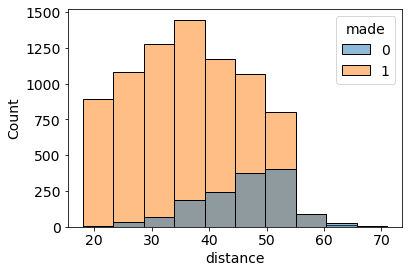

In [15]:
#histogram of all field goal attempts by distance, separated made and miss
sns.histplot(data=df, x="distance", hue='made',bins=10);

## Feature Selection

As we start to think about selecting features, we need to look at both the correlation between features (as we don't want multiple highly correlated variables), and those features that correlate highest with making a field goal.

In [16]:
#correlation matrix of all variables
df.corr()

,season,week,temperature,humidity,wind_speed,ou,home_spread,away_score,home_score,quarter,minutes,seconds,offense_score,defense_score,timeouts_offense,timeouts_defense,down,yards_to_go,yards_from_own_goal,points,penalty,fumble,block,play_id,kicker_id,distance,made,at_altitude,is_closed_roof,is_precipitating,is_end_of_half_or_game,kicker_leg_strength,kicker_accuracy,total_field_goals
season,1.000000,-0.004251,0.034549,0.027434,0.009728,0.129771,0.037942,0.065179,-0.001630,-0.003298,-0.029824,-0.001878,0.008856,0.035703,-0.006641,-0.034348,-0.012948,0.047863,-0.033588,-0.006854,0.020554,0.000236,-0.018704,0.993808,0.468210,0.034562,-0.013180,0.006954,-0.033443,0.006071,0.026103,0.051174,0.040832,-0.082554
week,-0.004251,1.000000,-0.482740,0.089309,0.021654,-0.025901,-0.014171,-0.055244,-0.020888,-0.014059,0.005983,0.000277,-0.015099,-0.025660,0.014843,0.011688,-0.000567,0.011694,0.005764,0.001718,-0.012847,-0.004316,0.012407,0.106507,0.010079,-0.005516,0.001590,0.017690,-0.003044,0.043964,0.004825,0.004047,0.052892,0.014161
temperature,0.034549,-0.482740,1.000000,-0.190030,-0.247480,0.097922,0.044988,0.074974,0.004625,0.006950,-0.001323,-0.006595,0.014710,0.016450,-0.012259,-0.014950,-0.025608,-0.010534,-0.037776,-0.002069,0.004145,-0.002094,-0.009268,-0.019563,0.013374,0.037915,-0.003722,-0.058513,0.300394,-0.168215,0.006151,0.016695,-0.048806,-0.055557
humidity,0.027434,0.089309,-0.190030,1.000000,-0.012170,-0.029697,-0.002812,-0.030524,-0.033374,0.006538,0.002071,-0.015473,-0.008746,-0.005453,-0.001673,-0.005640,-0.000643,0.025485,0.005558,-0.021343,-0.006925,-0.007572,0.009538,0.036896,-0.041621,-0.006024,-0.022899,-0.314027,0.000143,0.337714,0.001725,-0.013611,0.002096,0.046372
wind_speed,0.009728,0.021654,-0.247480,-0.012170,1.000000,-0.141318,0.037143,-0.091249,-0.058370,-0.006677,-0.007821,-0.003831,-0.031403,-0.033806,-0.013703,-0.012055,0.026775,0.000224,0.026784,-0.024650,-0.002068,0.001570,0.020484,0.011634,0.057844,-0.026353,-0.025457,0.040031,-0.626487,0.146138,0.006593,-0.075021,-0.009283,-0.031606
ou,0.129771,-0.025901,0.097922,-0.029697,-0.141318,1.000000,0.028986,0.217591,0.187837,-0.005607,0.004304,-0.007719,0.090270,0.103376,-0.003974,-0.003933,-0.013438,0.019613,-0.000308,0.013787,0.002086,-0.012897,-0.025008,0.125626,0.035152,0.001261,0.010996,-0.005065,0.148356,-0.053515,0.004507,-0.004611,0.037236,-0.002510
home_spread,0.037942,-0.014171,0.044988,-0.002812,0.037143,0.028986,1.000000,0.250901,-0.278104,0.011562,-0.003383,-0.014166,-0.008820,0.000097,-0.000495,-0.005999,-0.001811,-0.009696,-0.000643,0.001174,0.009404,0.006467,0.008218,0.036112,0.011340,-0.000144,0.002765,-0.030385,-0.043380,-0.037006,-0.000074,-0.005313,0.000519,-0.002159
away_score,0.065179,-0.055244,0.074974,-0.030524,-0.091249,0.217591,0.250901,1.000000,0.044398,0.025753,-0.016652,-0.013297,0.243706,0.301053,-0.030149,-0.030360,-0.039588,-0.001916,-0.016560,0.042683,0.016017,0.003318,-0.021491,0.058563,0.012669,0.016538,0.047030,-0.031499,0.048521,-0.063923,0.031614,0.017333,0.007472,-0.007258
home_score,-0.001630,-0.020888,0.004625,-0.033374,-0.058370,0.187837,-0.278104,0.044398,1.000000,0.001895,0.011831,0.006214,0.258023,0.257463,0.001880,0.005147,-0.013297,-0.006585,0.010923,0.041325,0.002850,0.002041,-0.025010,-0.003982,0.020569,-0.010323,0.041829,0.004998,0.047586,-0.005790,0.006596,-0.003943,0.014584,-0.007658
quarter,-0.003298,-0.014059,0.006950,0.006538,-0.006677,-0.005607,0.011562,0.025753,0.001895,1.000000,0.070923,0.009944,0.708883,0.641275,-0.104406,-0.225109,-0.029870,0.015373,-0.011196,0.004369,0.009944,-0.010735,0.002047,-0.004394,0.005209,0.010982,0.001845,0.001766,0.012344,0.003544,-0.025871,0.012017,0.005426,0.017007


In [17]:
#correlation with our target (making a field goal)
df[['made','kicker_accuracy','distance','yards_to_go','kicker_leg_strength','is_closed_roof','is_end_of_half_or_game','at_altitude','temperature','humidity','is_precipitating','wind_speed']].corr()['made'].sort_values(ascending=False)


made                      1.000000
kicker_accuracy           0.098897
kicker_leg_strength       0.024437
is_closed_roof            0.002884
at_altitude              -0.003306
temperature              -0.003722
humidity                 -0.022899
wind_speed               -0.025457
is_precipitating         -0.028588
is_end_of_half_or_game   -0.084889
yards_to_go              -0.093946
distance                 -0.333234
Name: made, dtype: float64

As we would expect, <b>distance</b> is by far the highest correlated variable with making a field goal.

Interestingly, <b>yards_to_go</b> is also a good predictor, but looking closer, this is because it is correlated with distance (0.292233). The closer a team is to the goal line, the lower their yards to go will be. The further away from the goal line, the larger the yards to go can be (e.g. you can't have a 4th-and-20 from the 5-yard line).

<b>kicker_accuracy</b> is our next highest correlated variable, and likely a good predictor of performance.

The last highly correlated variable is <b>is_end_of_half_or_game</b>. This tells us that if it's the end of the half or game, a kicker is <i>less</i> likely to make the field goal. Intuitively this makes sense - as time runs out, teams are sometimes forced to kick in situations where they would not normally kick.

Other potential features include: <b>wind_speed</b> (encompasses is_closed_roof), <b>is_precipitating</b>, <b>humidity</b> (correlated with is_precipitating and at_altitude), and <b>kicker_leg_strength</b>.

Leg strength is highly correlated with accuracy (0.471390), because our accuracy metric actually rewards kickers for harder/longer kicks.

<b>temperature</b>, <b>at_altitude</b>, <b>is_closed_roof</b> do not seem to have an effect.


In [18]:
potential_features = ['distance','kicker_accuracy','is_end_of_half_or_game','wind_speed','is_precipitating','humidity']

We have our list of potential features, now we are going to try out three different types of models. <b>Logistic regression</b> (or logit), <b>Random Forest</b>, and <b>XGBoost</b>. There are many more options to try, but we chose these three to give a general idea of the process.

Here, we are setting up a dictionary to collect and report accuracy metrics.

In [19]:
model_types = ['logit', 'random_forest', 'xgboost']
models = {}
predictions = {}

for name in model_types:
    models[name] = {}
    predictions[name] = {}

Next, we split our data into a <b>training</b> and <b>test</b> set, and split those into predictor variables (<b>X</b>) and our target variable (<b>Y</b>). Our goal is to be able to predict the probability of new, unseen data. We split into a training set and test set so that we can make predictions on pseudo-new data in the test set to ensure our model generalizes well.

There are a lot of papers and articles on the ideal test and training split. Test sets are generally around 20-30% of the data set. Here, we chose 30%.

There are two major considerations while deciding on the  split:

1. If there is less training data, the machine learning model will show high variance in training.
2. With less testing data/validation data, your model evaluation/model performance statistic will have greater variance.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df[potential_features], df['made'], test_size=0.3, random_state=0)

Here, we organized a few functions so that we don't repeat our code after each model we build. These functions help print outputs and accuracy metrics as we build our models. These functions names should be easily understood by anyone reading the notebook, even if they do not understand the code within them. For example, <b>printModelOutputsFromModelAndFeatures()</b> should print the output of a model as long as we pass in the model and it's features.

In [21]:
def printModelOutputsFromModelAndFeatures(model, features):
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    print('Accuracy')
    print(f'Train : {model.score(X_train_subset, y_train):.3f}')
    print(f'Test : {model.score(X_test_subset, y_test):.3f}')
    model_predicted = model.predict(X_test_subset)
    model_predicted_probabilities = model.predict_proba(X_test_subset)[:,1]
    print(f'AUC : {roc_auc_score(y_test, model_predicted_probabilities):.3f}')
    print(f'Log Loss : {log_loss(y_test, model_predicted_probabilities):.3f}')
    print(f'Brier : {brier_score_loss(y_test, model_predicted_probabilities):.3f}')
    print(classification_report(y_test, model_predicted))

In [22]:
def generateLogisticRegressionByFeaturesAndReturnModelWithTrainAndTestSets(features):
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    logit = LogisticRegression()
    logit.fit(X_train_subset, y_train)
    print("Intercept : " + str(logit.intercept_))
    print("Coefs : " + str(logit.coef_))
    print('Accuracy')
    printModelOutputsFromModelAndFeatures(logit, features)
    X_train2 = sm.add_constant(X_train_subset)
    est = sm.Logit(y_train, X_train2).fit()
    print(est.summary())
    print('\n')
    return logit

In [23]:
def printRocCurveByModelName(model_name):
    fpr, tpr, thresholds = roc_curve(y_test, predictions[model_name]['predicted_probabilities'])
    plt.figure()
    plt.plot(fpr, tpr, label=model_name + ' (area = %0.2f)' % models[model_name]['auc'])
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [24]:
def updateAccuracyMetricsByModelName(models, model_name):
    models[model_name]['auc'] = roc_auc_score(y_test, predictions[model_name]['predicted_probabilities'])
    models[model_name]['logloss'] = log_loss(y_test, predictions[model_name]['predicted_probabilities'])
    models[model_name]['brier'] = brier_score_loss(y_test, predictions[model_name]['predicted_probabilities'])
    return models

# Modeling

## Logistic Regression

Okay, it is finally time to start doing some machine learning and building models. We will start with a simple logistic regression encompassing all of our potential features.

In [25]:
logit = generateLogisticRegressionByFeaturesAndReturnModelWithTrainAndTestSets(potential_features)

Intercept : [6.56428165]
Coefs : [[-1.08823399e-01  4.17344174e+00 -2.38009369e-01 -1.38608165e-02
  -3.67533164e-01 -3.47399612e-03]]
Accuracy
Accuracy
Train : 0.851
Test : 0.843
AUC : 0.777
Log Loss : 0.369
Brier : 0.115
              precision    recall  f1-score   support

           0       0.53      0.07      0.12       441
           1       0.85      0.99      0.91      2344

    accuracy                           0.84      2785
   macro avg       0.69      0.53      0.52      2785
weighted avg       0.80      0.84      0.79      2785

Optimization terminated successfully.
         Current function value: 0.362484
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   made   No. Observations:                 6498
Model:                          Logit   Df Residuals:                     6491
Method:                           MLE   Df Model:                            6
Date:                Tue, 22 Feb

The initial results look pretty good! If you are a p-value person, all of the variables appear to be strong predictors except for <b>humidity</b>.

Next, since we know <b>distance</b> is the No. 1 predictor, let's set a baseline model, and try adding each other feature with distance to see which other variables give the most lift (e.g. which variables improve the accuracy metrics the most).

In [26]:
logit_models = {}
for feature in potential_features:
    print(feature)
    if feature == 'distance':
        logit = generateLogisticRegressionByFeaturesAndReturnModelWithTrainAndTestSets(['distance'])
        
        predicted_probabilities = logit.predict_proba(X_test[['distance']])[:,1]
        
        logit_models['distance'] = {}    
        logit_models['distance']['auc'] = roc_auc_score(y_test, predicted_probabilities)
        logit_models['distance']['logloss'] = log_loss(y_test, predicted_probabilities)
        logit_models['distance']['brier'] = brier_score_loss(y_test, predicted_probabilities)
        
    else: 
        logit = generateLogisticRegressionByFeaturesAndReturnModelWithTrainAndTestSets(['distance',feature])
        
        predicted_probabilities = logit.predict_proba(X_test[['distance', feature]])[:,1]
        
        if ('distance_and_' + str(feature)) not in logit_models:
            logit_models['distance_and_' + str(feature)] = {}
            logit_models['distance_and_' + str(feature)]['auc'] = {}
            logit_models['distance_and_' + str(feature)]['logloss'] = {}    
            logit_models['distance_and_' + str(feature)]['brier'] = {}    
        
        logit_models['distance_and_' + str(feature)]['auc'] = roc_auc_score(y_test, predicted_probabilities)
        logit_models['distance_and_' + str(feature)]['logloss'] = log_loss(y_test, predicted_probabilities)
        logit_models['distance_and_' + str(feature)]['brier'] = brier_score_loss(y_test, predicted_probabilities)

pprint.pprint(logit_models)    

distance
Intercept : [6.18691626]
Coefs : [[-0.10802129]]
Accuracy
Accuracy
Train : 0.850
Test : 0.842
AUC : 0.760
Log Loss : 0.378
Brier : 0.118
              precision    recall  f1-score   support

           0       0.53      0.05      0.08       441
           1       0.85      0.99      0.91      2344

    accuracy                           0.84      2785
   macro avg       0.69      0.52      0.50      2785
weighted avg       0.80      0.84      0.78      2785

Optimization terminated successfully.
         Current function value: 0.369816
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   made   No. Observations:                 6498
Model:                          Logit   Df Residuals:                     6496
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                  0.1409
Time:                        1

Log Loss : 0.377
Brier : 0.118
              precision    recall  f1-score   support

           0       0.57      0.05      0.09       441
           1       0.85      0.99      0.91      2344

    accuracy                           0.84      2785
   macro avg       0.71      0.52      0.50      2785
weighted avg       0.80      0.84      0.78      2785

Optimization terminated successfully.
         Current function value: 0.369377
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   made   No. Observations:                 6498
Model:                          Logit   Df Residuals:                     6495
Method:                           MLE   Df Model:                            2
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                  0.1419
Time:                        12:46:09   Log-Likelihood:                -2400.2
converged:                       True   LL-Null:                  

Based on the above models, and due to humidity's correlation with is_precipitating, we are dropping it from our features and selecting our final feature list. In all likelihood, we would only keep <b>distance</b> and <b>kicker_accuracy</b> as the other variables provide very little lift, but for the purpose of this presentation, we will use this full feature list for our Random Forest and XGBoost models as well. 

In [27]:
features = ['distance','kicker_accuracy','is_end_of_half_or_game','wind_speed','is_precipitating']
X_train = X_train[features]
X_test = X_test[features]

In [28]:
#final logistic model
logit = generateLogisticRegressionByFeaturesAndReturnModelWithTrainAndTestSets(features)

Intercept : [6.35688874]
Coefs : [[-0.10875539  4.16407602 -0.23767852 -0.01321856 -0.46341873]]
Accuracy
Accuracy
Train : 0.851
Test : 0.843
AUC : 0.777
Log Loss : 0.369
Brier : 0.115
              precision    recall  f1-score   support

           0       0.54      0.07      0.13       441
           1       0.85      0.99      0.91      2344

    accuracy                           0.84      2785
   macro avg       0.70      0.53      0.52      2785
weighted avg       0.80      0.84      0.79      2785

Optimization terminated successfully.
         Current function value: 0.362659
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   made   No. Observations:                 6498
Model:                          Logit   Df Residuals:                     6492
Method:                           MLE   Df Model:                            5
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                

Let's generate predictions and predicted probabilities so that we can save our logistic accuracy metrics.

In [29]:
predictions['logit']['predicted'] = logit.predict(X_test)
predictions['logit']['predicted_probabilities'] = logit.predict_proba(X_test)[:,1]

updateAccuracyMetricsByModelName(models, 'logit')
pprint.pprint(models)

{'logit': {'auc': 0.7766730127773521,
           'brier': 0.11534692579056031,
           'logloss': 0.3692686366964287},
 'random_forest': {},
 'xgboost': {}}


Here is an example of an ROC curve that can be used to identify the trade off between sensitivity and specificity in the model.

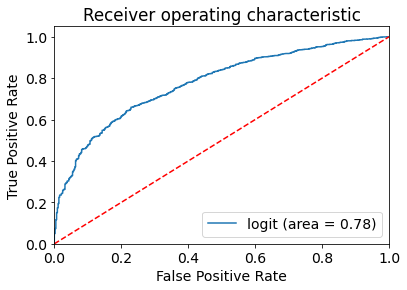

In [30]:
printRocCurveByModelName('logit')

## Random Forest

Let's try a <b>random forest</b> classifier and see how it performs compared to a logistic regression. We will seed it with basic values provided by the python package.

In [31]:
randomForest = RandomForestClassifier()
randomForest.fit(X_train, y_train)
printModelOutputsFromModelAndFeatures(randomForest, features)

Accuracy
Train : 0.975
Test : 0.797
AUC : 0.698
Log Loss : 0.707
Brier : 0.144
              precision    recall  f1-score   support

           0       0.29      0.19      0.23       441
           1       0.86      0.91      0.88      2344

    accuracy                           0.80      2785
   macro avg       0.57      0.55      0.56      2785
weighted avg       0.77      0.80      0.78      2785



### Parameter Tuning - Grid Search

The results are okay, but let's try to improve them. Here, we are performing a full grid search to optimize the random forest parameters.

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

#Maximum number of levels in tree
max_depth = [2,4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
             }

In [33]:
randomForestGrid = RandomizedSearchCV(estimator = randomForest, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1')
randomForestGrid.fit(X_train, y_train)
printModelOutputsFromModelAndFeatures(randomForestGrid, features)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Accuracy
Train : 0.922
Test : 0.914
AUC : 0.770
Log Loss : 0.374
Brier : 0.117
              precision    recall  f1-score   support

           0       0.52      0.06      0.10       441
           1       0.85      0.99      0.91      2344

    accuracy                           0.84      2785
   macro avg       0.68      0.52      0.51      2785
weighted avg       0.80      0.84      0.79      2785



In [34]:
randomForestGrid.best_estimator_

RandomForestClassifier(max_depth=6, min_samples_leaf=2, n_estimators=250)

After our search, we've outputted the best parameters that we found. Let's make the predictions and update our accuracy metrics to compare against our logistic regression.

In [35]:
predictions['random_forest']['predicted'] = randomForestGrid.predict(X_test)
predictions['random_forest']['predicted_probabilities'] = randomForestGrid.predict_proba(X_test)[:,1]

In [36]:
updateAccuracyMetricsByModelName(models, 'random_forest')
pprint.pprint(models)

{'logit': {'auc': 0.7766730127773521,
           'brier': 0.11534692579056031,
           'logloss': 0.3692686366964287},
 'random_forest': {'auc': 0.7695795895149868,
                   'brier': 0.11671654255364923,
                   'logloss': 0.37416640523720074},
 'xgboost': {}}


## XGBoost

Last, we are going to look at an <b>XGBoost</b> classification model. Similar to the random forest model, this can be improved with some parameter tuning. Here, we are also adding <b>monotonic constraints</b>. Since machine learning models can overfit, these constraints ensure that as distance increases, field goal make probability decreases. Similarly, it ensures that as kicker accuracy increases, field goal make probability increases.

In [37]:
xgBoost = XGBClassifier(objective='binary:logistic', eval_metric="logloss", 
                        use_label_encoder=False, monotone_constraints = "(-1,1,0,-1,-1)")
xgBoost.fit(X_train, y_train)
printModelOutputsFromModelAndFeatures(xgBoost, features)

Accuracy
Train : 0.857
Test : 0.843
AUC : 0.772
Log Loss : 0.377
Brier : 0.117
              precision    recall  f1-score   support

           0       0.53      0.11      0.18       441
           1       0.85      0.98      0.91      2344

    accuracy                           0.84      2785
   macro avg       0.69      0.54      0.55      2785
weighted avg       0.80      0.84      0.80      2785



Let's do a random search to tune the XGBoost parameters.

In [38]:
xgboost_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [.05, .1, .2, .3],
        'n_estimators': [25, 50, 100, 250, 500]
        }

folds = 3
param_comb = 6

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

xgBoostRandomSearch = RandomizedSearchCV(xgBoost, param_distributions=xgboost_params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=0, random_state=1001)
xgBoostRandomSearch.fit(X_train, y_train)
printModelOutputsFromModelAndFeatures(xgBoostRandomSearch, features)

Accuracy
Train : 0.785
Test : 0.773
AUC : 0.773
Log Loss : 0.373
Brier : 0.117
              precision    recall  f1-score   support

           0       0.46      0.07      0.13       441
           1       0.85      0.98      0.91      2344

    accuracy                           0.84      2785
   macro avg       0.66      0.53      0.52      2785
weighted avg       0.79      0.84      0.79      2785



In [39]:
print('Best estimator:')
print(xgBoostRandomSearch.best_estimator_)
print('\nBest normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(xgBoostRandomSearch.best_score_ * 2 - 1)
print('\nBest hyperparameters:')
print(xgBoostRandomSearch.best_params_)

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='logloss', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan,
              monotone_constraints='(-1,1,0,-1,-1)', n_estimators=25, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Best normalized gini score for 3-fold search with 6 parameter combinations:
0.5479760325396092

Best hyperparameters:
{'subsample': 0.8, 'n_estimators': 25, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6}


Let's store our XGBoost predictions from the best model that we found and compare results to choose a final model.

In [40]:
predictions['xgboost']['predicted'] = xgBoostRandomSearch.predict(X_test)
predictions['xgboost']['predicted_probabilities'] = xgBoostRandomSearch.predict_proba(X_test)[:,1]

In [41]:
models = updateAccuracyMetricsByModelName(models, 'xgboost')
pprint.pprint(models)

{'logit': {'auc': 0.7766730127773521,
           'brier': 0.11534692579056031,
           'logloss': 0.3692686366964287},
 'random_forest': {'auc': 0.7695795895149868,
                   'brier': 0.11671654255364923,
                   'logloss': 0.37416640523720074},
 'xgboost': {'auc': 0.7725664213353145,
             'brier': 0.1165191336982656,
             'logloss': 0.37259622812505205}}


# Final Model Selection

Based on these results, the <b><i>logistic regression</i></b> performs best. The <b>area under the curve (AUC)</b> is highest, and both <b>brier</b> score and <b>logloss</b> are lowest (closer to zero is better).

<b><u>Logistic Regression Formula</u></b>

In [42]:
print("1 / (1 + Math.exp(-(" + str(logit.intercept_[0]) + ' ' + (' + '.join([str(a) + " * " + str(b) for a,b in zip(logit.coef_[0],features)])) + ")))")

1 / (1 + Math.exp(-(6.3568887366647715 -0.10875539013350857 * distance + 4.1640760168001405 * kicker_accuracy + -0.23767851959086614 * is_end_of_half_or_game + -0.013218559158871072 * wind_speed + -0.46341872708936555 * is_precipitating)))


## The End
<br>
<br>
<br>
<br>

### So, what did we do wrong?

Did you notice that we made an error in calculating our kicker analytics? It is important to only use kicks <i>before</i> each field goal that was attempted so that we are not making predictions with data we would not have had available to us at the time. Above, however, we are incorrectly measuring a kicker's ability based on their full output in the data set. For example, to calculate Justin Tucker's kicking data in 2018, we used kicking stats that included 2018, 2019 and 2020 data. In data science, this is called <b><i>leakage</i></b> and it will likely cause the predictive scores to overestimate the model's utility when run in a production environment.

How would you go about fixing this?

Here are some ideas:

1. Treat the kicker data as a <b>time series</b>. This can require shifting columns up or down to see how values change over time.
2. Think about how you would handle empty values (e.g. games at altitude or end of the first half where we were not using them in our data set due to bias).
3. Think about how you would handle kickers with little or no kicker analytics (e.g. how would you handle a kicker's first kick attempt?). For this, using <b>regression to the mean</b> can be very helpful.

Below is an example of code working through these three things.

In [ ]:
#get average of 5 longest kicks and average field_goals_over_expectation

#sort by kicker id and play id chronologically to set it up as a time series
field_goals_for_kicker_analysis = field_goals_for_kicker_analysis.sort_values(['kicker_id','play_id'], ascending=(True,True))

#shift field_goals_over_expectation and distance down a row to calculate out of sample kicker analytics (we do not want to include the current kick in our analytics since that data should be unseen)
field_goals_for_kicker_analysis['previous_field_goals_over_expectation'] = field_goals_for_kicker_analysis['field_goals_over_expectation'].shift(1)
field_goals_for_kicker_analysis['previous_distance'] = field_goals_for_kicker_analysis['distance'].shift(1)

#add previous kicker id so we can filter out the first new kick for a kicker
field_goals_for_kicker_analysis['previous_kicker_id'] = field_goals_for_kicker_analysis['kicker_id'].shift(1)
field_goals_for_kicker_analysis.loc[field_goals_for_kicker_analysis['previous_kicker_id'] != field_goals_for_kicker_analysis['kicker_id'], 'previous_field_goals_over_expectation'] = 0
field_goals_for_kicker_analysis.loc[field_goals_for_kicker_analysis['previous_kicker_id'] != field_goals_for_kicker_analysis['kicker_id'], 'previous_distance'] = 0

#add column calculating total field goals up to that point in each kicker's data set, excluding current field goal attempt
field_goals_for_kicker_analysis = field_goals_for_kicker_analysis.assign(total_field_goals=field_goals_for_kicker_analysis.groupby('kicker_id', sort=False)['made'].transform(lambda x: x.expanding().count() - 1))

#drop first kick for each kicker since we have no data for it
field_goals_for_kicker_analysis = field_goals_for_kicker_analysis.drop(field_goals_for_kicker_analysis[field_goals_for_kicker_analysis['total_field_goals'] == 0].index)

#add column calculating average field goals over expectation up to that point in each kicker's data set, excluding current field goal attempt
field_goals_for_kicker_analysis = field_goals_for_kicker_analysis.assign(kicker_accuracy=field_goals_for_kicker_analysis.groupby('kicker_id', sort=False)['previous_field_goals_over_expectation'].transform(lambda x: x.expanding().mean()))

#add column calculating average of top 5 longest field goals up to that point in each kicker's data set, excluding current field goal attempt
field_goals_for_kicker_analysis = field_goals_for_kicker_analysis.assign(kicker_leg_strength=field_goals_for_kicker_analysis.groupby('kicker_id', sort=False)['previous_distance'].transform(lambda x: x.expanding().apply(lambda n: n.nlargest(5).mean())))

#drop shifted columns
field_goals_for_kicker_analysis.drop(columns=['previous_field_goals_over_expectation', 'previous_distance', 'previous_kicker_id'], inplace=True)

For empty values in our kicker analytics - because we excluded kicks at altitude and those in the final seconds of the half - we fill each empty cell with the last valid entry. For example, if Brandon McManus is kicking at Mile High in Week 16, it will pull his analytics from his most recent qualifying kick not at Mile High (e.g. Week 15).

In [ ]:
kicker_analytics_labels = ['kicker_accuracy', 'kicker_leg_strength', 'total_field_goals']

for label in kicker_analytics_labels:
    df[label] = df.sort_values('play_id').groupby('kicker_id')[label].fillna(method='pad')

Here is an example of how we might regress our kicker stats to the mean so that we have reasonable kicker analytics for the entire data set. Below, we are using 50 kicks as the stabilization point - we will not go into how this can be calculated as it is a subject for another presentation. The general idea, though, is that we are assuming kicking ability stabilizes after around 50 kicks, so we will add 50 kicks of league-average performance to each kicker's analytics.

In [ ]:
league_average_kicker_accuracy = round(test_accuracy.kicker_accuracy.mean(),2)
league_average_kicker_leg_strength = round(test_leg_strength.kicker_leg_strength.mean(),2)

kicker_stabilization_point = 50;

df['kicker_accuracy'] = (df['kicker_accuracy'] * df['total_field_goals'] + kicker_stabilization_point * league_average_kicker_accuracy) / (df['total_field_goals'] + kicker_stabilization_point) 
df['kicker_leg_strength'] = (df['kicker_leg_strength'] * df['total_field_goals'] + kicker_stabilization_point * league_average_kicker_leg_strength) / (df['total_field_goals'] + kicker_stabilization_point) 
df['total_field_goals'] = df['total_field_goals'] + kicker_stabilization_point

df['kicker_accuracy'].fillna(league_average_kicker_accuracy, inplace = True)
df['kicker_leg_strength'].fillna(league_average_kicker_leg_strength, inplace = True)
df['total_field_goals'].fillna(0, inplace = True)